# Analysis of dumps
## Raw Data
The test suite stores tcpdump output in a json format. Because this contains information about each packet, it can be parsed to determine information that would not normally be revealed by the transfer program itself. For example, how much overhead or compression there was.

In [1]:
from helpers import get_dump_fnames, get_dumps, organize_dumps

PROTOCOLS = ["scp", "hpn-scp", "ftp", "gridftp"]
N = None # The number of records to retrieve (None=all)

# Find the relevant dumps
names = get_dump_fnames(PROTOCOLS, N)
dumps = get_dumps(names)

# Fetch relevant columns and rename them
df, ids = organize_dumps(dumps)

## Remove outliers
The data doesn't tend to have outliers for large filesizes, but with file less than 10Mb there can be some anomalies

In [2]:
sel = df[df["File Size (bytes)"] < 10000000] # Choose everything less than 10Mb
# If the ratio of filesize to packets is more than 1 million, there is a problem
outliers = sel[sel["Bytes Total"]/sel["File Size (bytes)"] > 1000000]

# Remove only those lines. For now, leave the rest of the batch
df.drop(outliers.index, inplace=True)

## Aggregate Data
The table above can be aggregated per filesize and protocol, then displayed visually.

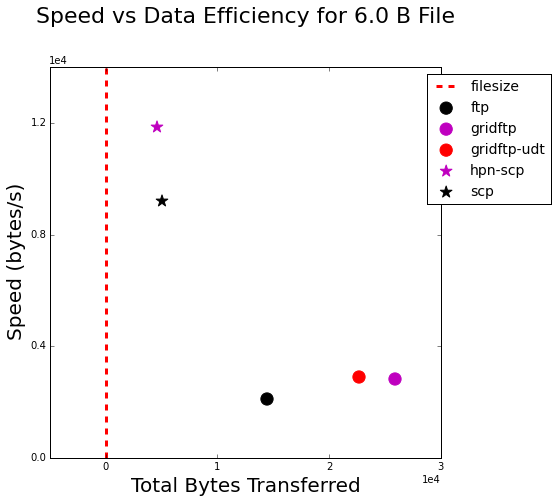

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt, rcParams
from ipywidgets import interact, fixed
import numpy as np
import pandas as pd

from plot import plot_speed_efficiency

rcParams['figure.figsize'] = (7, 7)

# Group by Filesize and then Protocol
agg = df.groupby(["File Size (bytes)", "Protocol"]).aggregate(np.mean)
agg.drop(["Batch ID"], axis=1, inplace=True)

sizes = {str(x):x for x in set(df["File Size (bytes)"])}
agg_interact = interact(plot_speed_efficiency, df=fixed(agg), filesize=sizes)

In [4]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)

agg

Bytes Down  Bytes Up  Bytes Total  Ratio (%)  \
File Size (bytes) Protocol                                                     
6                 ftp               2569.0   11880.3      14449.3   240822.2   
                  gridftp           3293.0   22625.2      25918.2   431970.8   
                  gridftp-udt       3285.8   19451.4      22737.2   378953.3   
                  hpn-scp           1693.0    2934.2       4627.2    77120.0   
                  scp               1825.0    3212.6       5037.6    83960.0   
366448122         ftp          355460026.6  869439.8  356329466.4       97.2   
                  gridftp      365214569.4    4491.0  365219060.4       99.7   
                  gridftp-udt  373077927.4  120205.4  373198132.8      101.8   
                  hpn-scp      366891566.6  116639.0  367008205.6      100.2   
                  scp          366804940.2  130643.0  366935583.2      100.1   
1535115264        ftp         1529632423.4 3596729.4 1533229152.8       99.9   
                  gridftp     1532645988.2    4491.0 1532650479.2       99.8   
                  gridftp-udt 1593804982.6  490088.6 1594295071.2      103.9   
                  hpn-scp     1515602696.2  497436.6 1516100132.8       98.8   
                  scp         1537618930.6  565835.0 1538184765.6      100.2   
2540610608        ftp         2540852365.8 6027097.4 2546879463.2      100.2   
                  gridftp     2540120751.4    4491.0 2540125242.4      100.0   
                  gridftp-udt 2641575978.6  803853.4 2642379832.0      104.0   
                  hpn-scp     2522343038.6  823407.0 2523166445.6       99.3   
                  scp         2514140996.2  913355.0 2515054351.2       99.0   

                               Time (s)  Speed (bytes/s)  
File Size (bytes) Protocol                                
6                 ftp               1.2           2120.2  
                  gridftp           1.2           2822.4  
                  gridftp-udt       1.2           2891.5  
                  hpn-scp           0.2          11844.8  
                  scp               0.5           9206.2  
366448122         ftp              17.6       20347580.7  
                  gridftp          20.2       18477235.1  
                  gridftp-udt      22.3       16998871.5  
                  hpn-scp          18.3       20185242.8  
                  scp              16.8       22113979.8  
1535115264        ftp              69.8       21941362.5  
                  gridftp          69.5       22099153.3  
                  gridftp-udt      72.0       22152734.0  
                  hpn-scp          65.6       23118723.7  
                  scp              65.3       23570796.3  
2540610608        ftp             115.2       22078301.8  
                  gridftp         120.8       21030954.8  
                  gridftp-udt     118.6       22278116.5  
                  hpn-scp         110.4       22849466.7  
                  scp             113.0       22256625.2

## Metrics per filesize
The above data can also be shown as a function of filesize

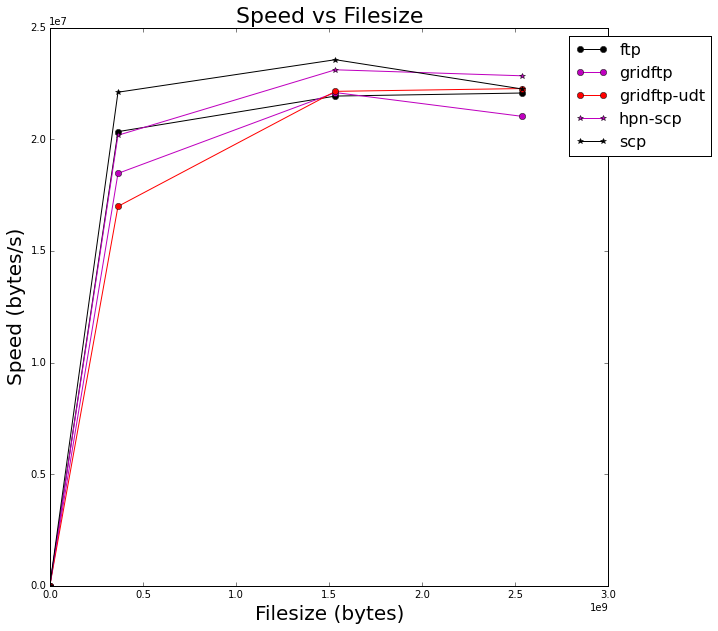

In [ ]:
%matplotlib inline
from plot import plot_speed_per_filesize

rcParams['figure.figsize'] = (10, 10)        

plot_speed_per_filesize(df, ratio=False)

## Topography of Transfer
Displaying the packet sizes against a time axis gives more insight into each protocol. It's also a good representation of network conditions, as breaks or delays are easily seen.

In [ ]:
%matplotlib inline
from plot import plot_packets
import warnings

warnings.simplefilter('ignore', UserWarning)
rcParams['figure.figsize'] = (12, 12)

def reverse_lookup(bid):
    for key, val in ids.items():
        if val == bid:
            return key
    return None

batch_ids = {str(x):reverse_lookup(x) for x in set(df["Batch ID"])}
packet_interact = interact(plot_packets, batch_id=batch_ids)